In [5]:
import os
from pathlib import Path
PARENT_PATH = Path(os.getcwd()).parent.absolute()

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass

import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import collections

import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)

In [ ]:
xls = pd.ExcelFile(os.path.join(data.data_path, "Regulatory Requirements.xlsx"))
df = pd.read_excel(xls,'Requirements List')

In [7]:
df1 = df[df['Mapped to a standard?'] != 'No mapping']
df1.reset_index(drop=True, inplace=True)
df1['Standard mapping?'].replace('\n',',', regex=True,inplace = True)
df1['Standard mapping?'] = df1['Standard mapping?'].str.replace(r'^[\s,]+|[\s,]+$|(\s)*(,)[\s,]*', r'\2\1', regex=True)
df1['Standard mapping?'] = df1['Standard mapping?'].str.split(',')

n = df1.shape[0]
for i in range(n):
    for j in range(len(df1['Standard mapping?'][i])):
        if df1['Standard mapping?'][i][j].lower() == 'vmp':
            df1['Standard mapping?'][i][j] = 'VMP'

In [11]:
df1["Text"][0]

'General Quality System Requirements […] General Provisions […]\nEach manufacturer shall establish and maintain a quality system to ensure that the requirements of this Technical Regulation are met and that the products produced are safe, effective and appropriate for the intended use. As part of the activities in the quality system, each manufacturer shall:\n1. Establish and maintain effective procedures and instructions of the quality system according to the requirements of this Technical Regulation, and\n2. Establish procedures for meeting the established legal provisions in the current health surveillance legislation.'

In [ ]:
import pandas as pd
categories = pd.read_excel(os.path.join(data.data_path, "Regulatory Requirements.xlsx"))[3:]
categories = categories.reset_index(drop = True)
categories = categories.rename(columns={'Unnamed: 0': 'Categories', 'Unnamed: 1': 'count','Unnamed: 2': 'No mapping'})
categories

<AxesSubplot:title={'center':'The most common categories'}, xlabel='Categories', ylabel='count'>

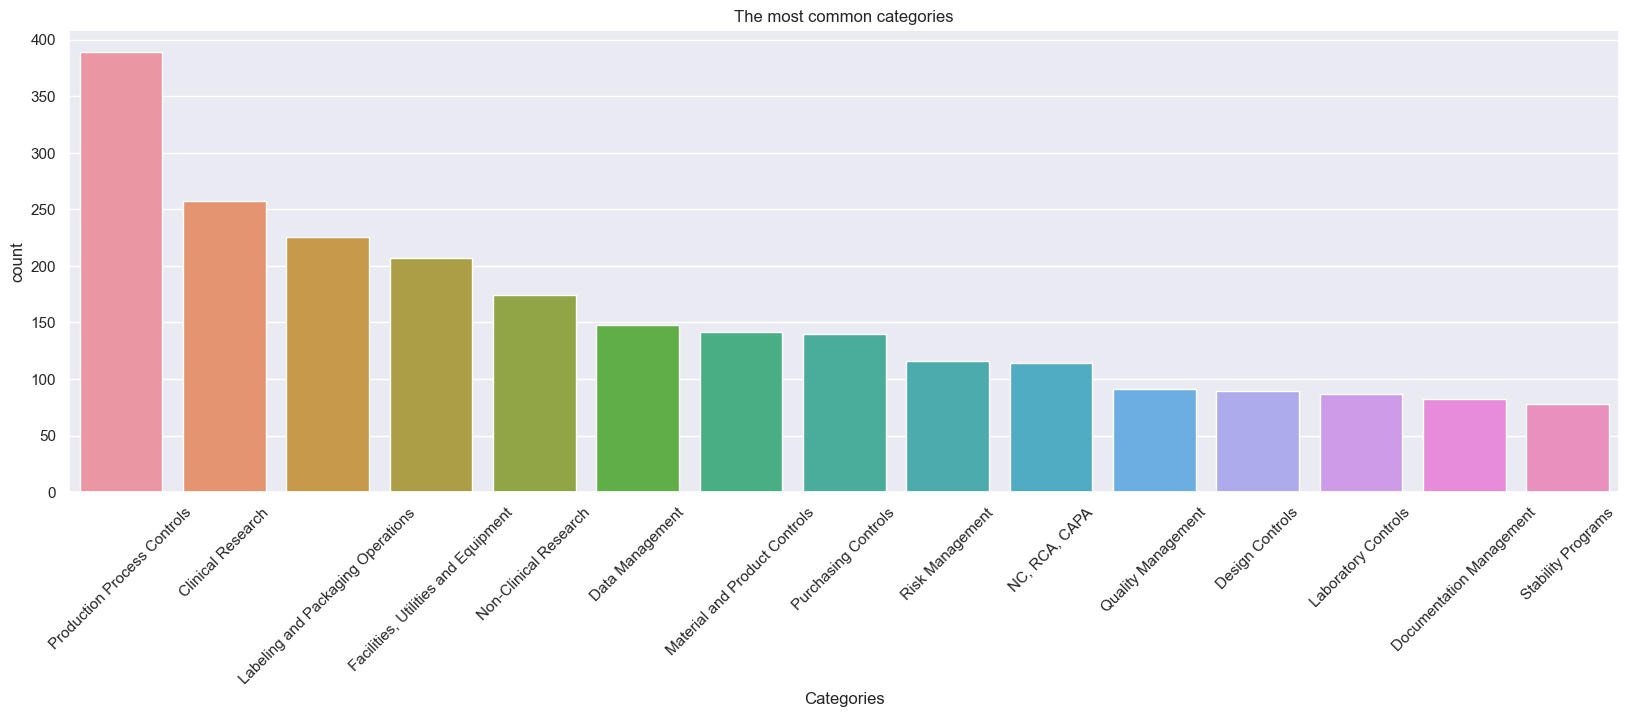

In [63]:
plt.figure(figsize = (20,6))
plt.xticks(rotation=45)
plt.title("The most common categories")
sns.barplot(categories[:15], x = "Categories", y = "count")

In [18]:
training_data = pd.read_csv(os.path.join(data.data_path, "jnj_hygiene_ft_training_data.csv"))
training_data[:20]

,prompt,completion,char_length
0,Text: (2) The sanitation program referred to i...,hygiene,254
1,Text: (3) Washing hands thoroughly (and saniti...,hygiene,269
2,"Text: (8) Not eating food, chewing gum, drinki...",hygiene,223
3,Text: (9) Taking any other precautions necessa...,hygiene,311
4,Text: (a) Your production and in-process cont...,other,524
5,Text: (a) Management should ensure appropriate...,other,401
6,Text: (a) Senior Management has the ultimate r...,other,1328
7,Text: (a) You must make and keep records requi...,other,1399
8,Text: (a) You must prepare and follow a writte...,other,862
9,Text: (b) Laboratory controls shall include th...,other,1787


<AxesSubplot:title={'center':'No.hygiene vs No.other'}, xlabel='completion', ylabel='Count'>

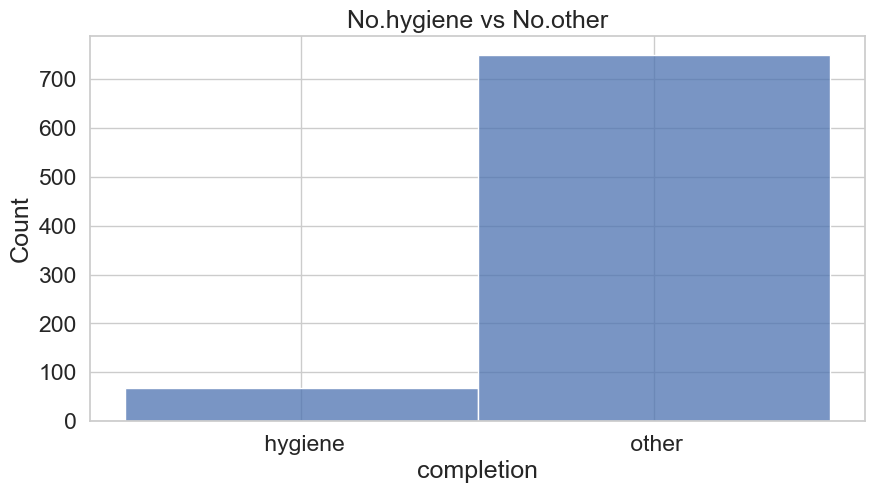

In [19]:
plt.figure(figsize = (10,5))
plt.title("No.hygiene vs No.other")
sns.histplot(training_data, x = "completion")

In [52]:
from collections import defaultdict
word_frequency = defaultdict(int)
word_frequency_hygiene = defaultdict(int)
word_frequency_other = defaultdict(int)
avg_sentence_length = {"hygiene":[0,0], "other":[0,0]}
avg_word_length = {"hygiene":[0,0], "other":[0,0]}
stop_words = set(stopwords.words('english'))
stop_words = stop_words.union(set(["shall", "Text:", "[...]"]))
for row in range(training_data.shape[0]):
    lines = training_data["prompt"][row].split("\n")
    for line in lines:
        line = " ".join(re.sub("([^A-Za-z ]+)|(\w+:\/\/\S+)|(\(\))", "", line).split())
        line= line.lower().split()
        print(line)
        if training_data["completion"][row].strip() == "hygiene":
            avg_sentence_length["hygiene"][0] = (avg_sentence_length["hygiene"][0]*avg_sentence_length["hygiene"][1] + len(line))/(avg_sentence_length["hygiene"][1]+1)
            avg_sentence_length["hygiene"][1] += 1
        else:
            avg_sentence_length["other"][0] = (avg_sentence_length["other"][0]*avg_sentence_length["other"][1] + len(line))/(avg_sentence_length["other"][1]+1)
            avg_sentence_length["other"][1] += 1
        words = training_data["prompt"][row].split()
        for word in words:
            if word not in stop_words:
                word_frequency[word] += 1
                if training_data["completion"][row].strip() == "hygiene":
                    avg_word_length["hygiene"][0] = (avg_word_length["hygiene"][0]*avg_word_length["hygiene"][1] + len(word))/(avg_word_length["hygiene"][1]+1)
                    avg_word_length["hygiene"][1] += 1
                    word_frequency_hygiene[word] += 1
                else:
                    avg_word_length["other"][0] = (avg_word_length["other"][0]*avg_word_length["other"][1] + len(word))/(avg_word_length["other"][1]+1)
                    avg_word_length["other"][1] += 1
                    word_frequency_other[word] += 1
summary_df = {"Category": ["hygiene", "other"], "avg_sentence_length": [avg_sentence_length["hygiene"][0], avg_sentence_length["other"][0]], "sentence_count": [avg_sentence_length["hygiene"][1], avg_sentence_length["other"][1]],
              "avg_word_length":[avg_word_length["hygiene"][0], avg_word_length["other"][0]], "word_count": [avg_word_length["hygiene"][1], avg_word_length["other"][1]]}
summary_df = pd.DataFrame(summary_df)

['text', 'the', 'sanitation', 'program', 'referred', 'to', 'in', 'subsection', 'shall', 'include']
['b', 'instructions', 'on', 'the', 'sanitary', 'fabrication', 'and', 'packaginglabelling', 'of', 'drugs', 'and', 'the', 'handling', 'of', 'materials', 'used', 'in', 'the', 'fabrication', 'and', 'packaginglabelling', 'of', 'drugs']
['category']
['text', 'washing', 'hands', 'thoroughly', 'and', 'sanitizing', 'if', 'necessary', 'to', 'protect', 'against', 'contamination', 'with', 'microorganisms', 'in', 'an', 'adequate', 'handwashing', 'facility']
['i', 'before', 'starting', 'work', 'and']
['ii', 'at', 'any', 'time', 'when', 'the', 'hands', 'may', 'have', 'become', 'soiled', 'or', 'contaminated']
['category']
['text', 'not', 'eating', 'food', 'chewing', 'gum', 'drinking', 'beverages', 'or', 'using', 'tobacco', 'products', 'in', 'areas', 'where', 'components', 'dietary', 'supplements', 'or', 'any', 'contact', 'surfaces', 'are', 'exposed', 'or', 'where', 'contact', 'surfaces', 'are', 'washed',

In [45]:
summary_df

,Category,avg_sentence_length,sentence_count,avg_word_length,word_count
0,hygiene,18.416667,156,7.463007,4609
1,other,14.259295,3093,7.572034,165770


<AxesSubplot:title={'center':'The most common words'}>

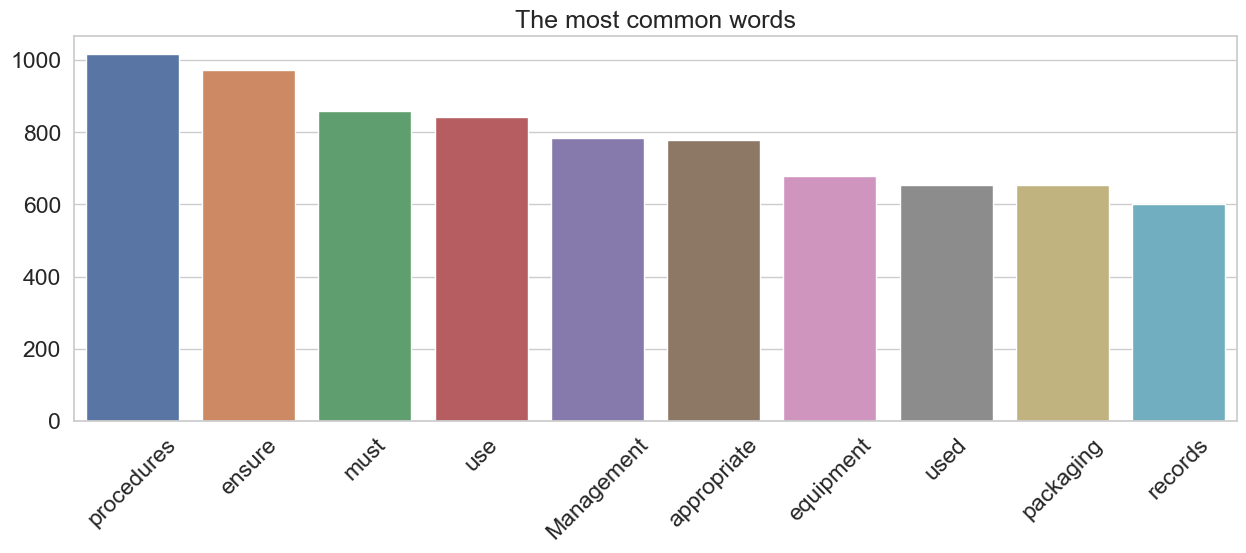

In [55]:
import heapq
meaningful_20_word = heapq.nlargest(20, word_frequency, key=word_frequency.get)[10:]
meaningful_20_count = heapq.nlargest(20, word_frequency.values())[10:]
plt.figure(figsize = (15,5))
plt.xticks(rotation=45)
plt.title("The most common words")
sns.barplot(x = meaningful_20_word, y = meaningful_20_count)


<AxesSubplot:title={'center':'The most common words in other'}>

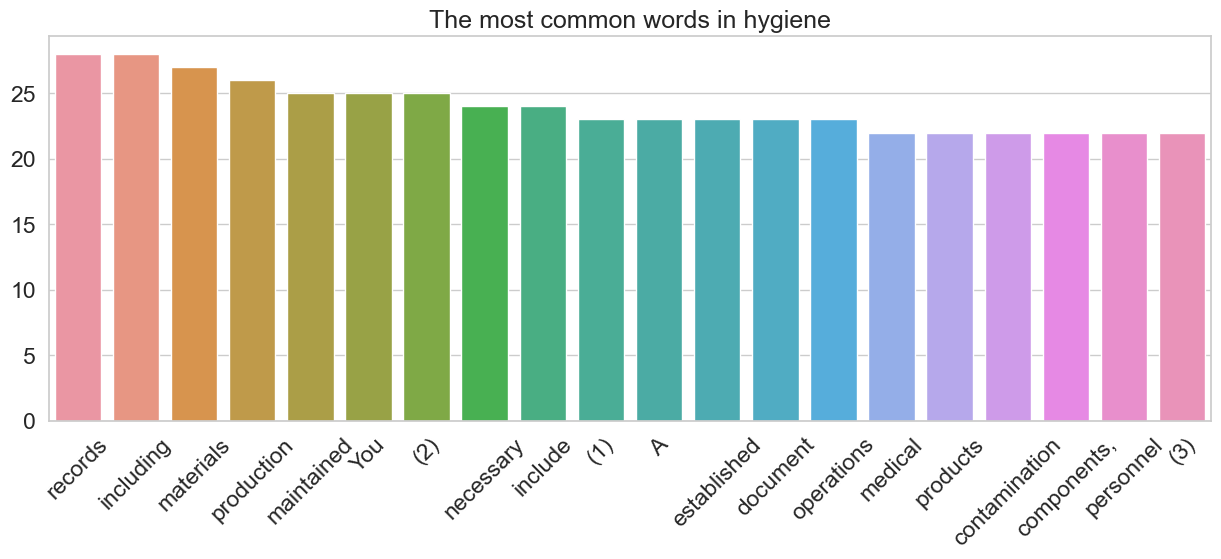

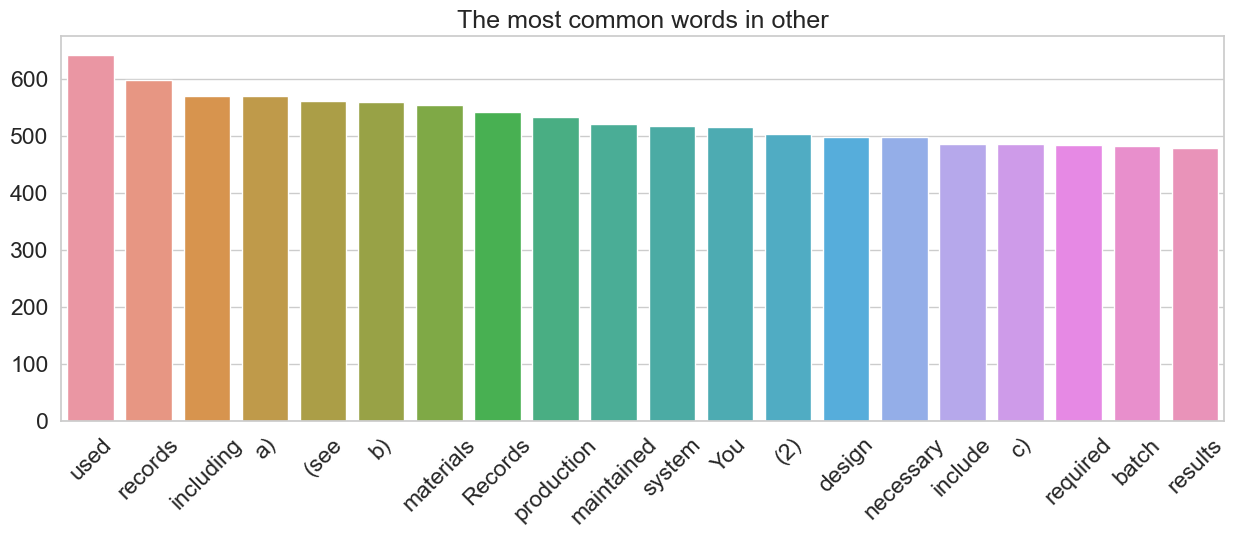

In [37]:
meaningful_20_word_hygiene = heapq.nlargest(40, word_frequency_hygiene, key=word_frequency.get)[20:]
meaningful_20_count_hygiene = heapq.nlargest(40, word_frequency_hygiene.values())[20:]
meaningful_20_word_other = heapq.nlargest(40, word_frequency_other, key=word_frequency.get)[20:]
meaningful_20_count_other = heapq.nlargest(40, word_frequency_other.values())[20:]
plt.figure(figsize = (15,5))
plt.xticks(rotation=45)
plt.title("The most common words in hygiene")
sns.barplot(x = meaningful_20_word_hygiene, y = meaningful_20_count_hygiene)
plt.figure(figsize = (15,5))
plt.xticks(rotation=45)
plt.title("The most common words in other")
sns.barplot(x = meaningful_20_word_other, y = meaningful_20_count_other)

In [80]:
summary_df

,Category,avg_sentence_length,sentence_count,avg_word_length,word_count
0,hygiene,125.647436,156,5.736849,7452
1,other,101.930812,3093,5.935378,252606


<AxesSubplot:title={'center':'Average Word Length'}, xlabel='Category', ylabel='avg_word_length'>

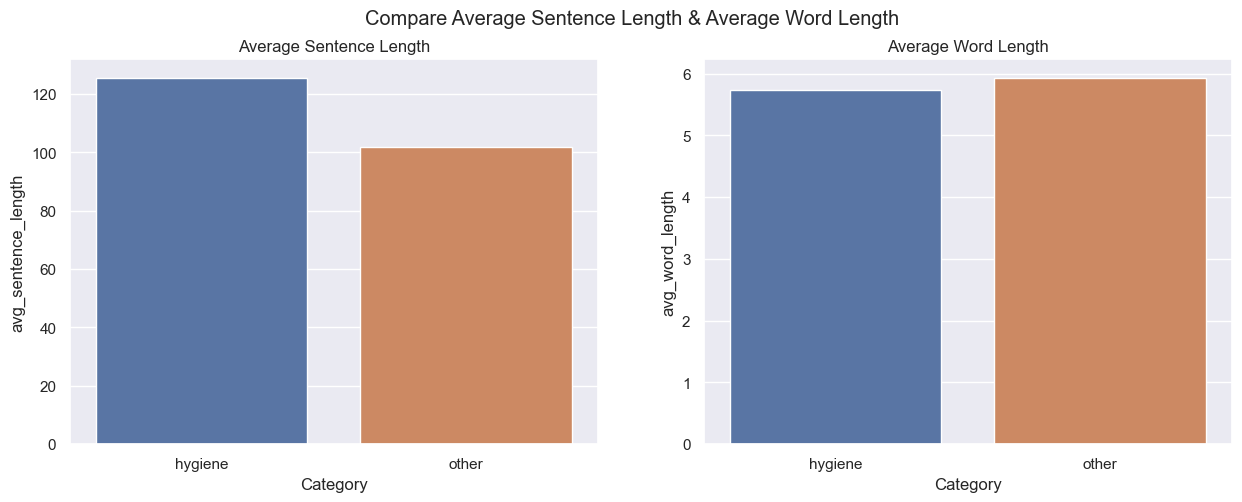

In [83]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle("Compare Average Sentence Length & Average Word Length")
axes[0].set_title('Average Sentence Length')
axes[1].set_title('Average Word Length')
sns.barplot(summary_df, x = "Category", y = "avg_sentence_length", ax=axes[0])
sns.barplot(summary_df, x = "Category", y = "avg_word_length", ax=axes[1])

<AxesSubplot:title={'center':'Word Count'}, xlabel='Category', ylabel='word_count'>

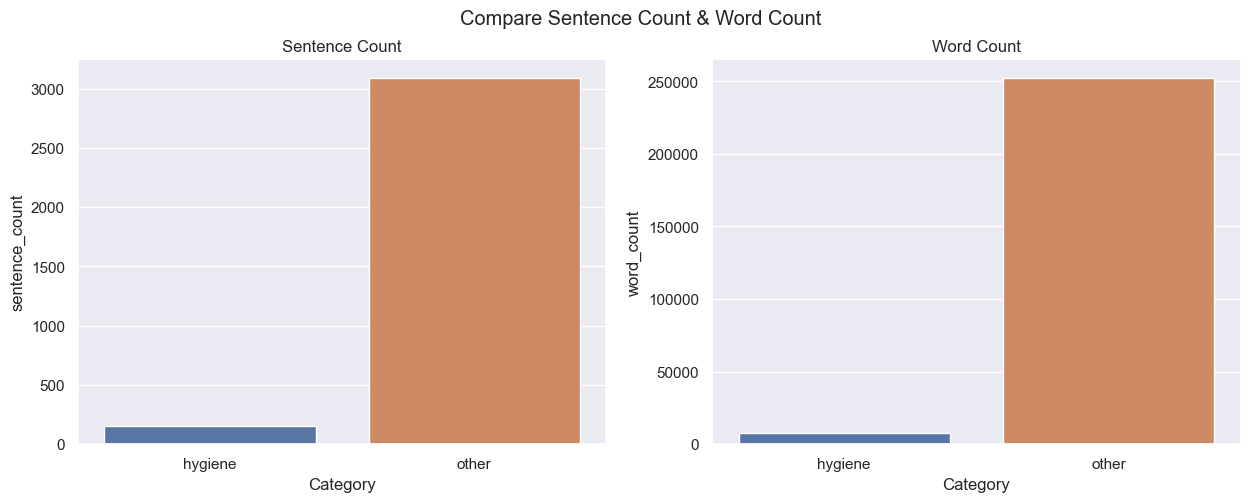

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle("Compare Sentence Count & Word Count")
axes[0].set_title('Sentence Count')
axes[1].set_title('Word Count')
sns.barplot(summary_df, x = "Category", y = "sentence_count", ax=axes[0])
sns.barplot(summary_df, x = "Category", y = "word_count", ax=axes[1])